In [1]:
import numpy as np
import re
import random
import itertools
import datetime

import tensorflow as tf
import sklearn as sk

from gensim.models import Word2Vec

import Functions as fn
from DS import DS
from Set import pool
from Iterator import Iterator
from FFModel import FF_Model

C:\Users\Luka\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
Dataset = pool()
Dataset.load_texts('raw_texts')
Dataset.load_labels('raw_labels')

Raw Text Load Complete
Raw Labels Load Complete


# Horizontal Metrics

In [173]:
a = {1:2}
a

{1: 2}

In [99]:
all_set = Dataset.get_DS(labelled='yes')
train_set = pool(data=(Dataset.get_DS(stage='test', labelled='yes')).data[:-10])
validation_set = pool(data=(Dataset.get_DS(stage='test', labelled='yes')).data[-10:])
test_set = Dataset.get_DS(stage='train', labelled='yes')
ehrs = [train_set.size, validation_set.size, test_set.size, all_set.size]

In [162]:
eps = []
ens = []
pns = []
tns = []
dns = []
vocs = []
for seti in [train_set, validation_set, test_set, all_set]:
#for seti in [pool(test_set.data[1:2])]:
    ep = [0, 0, 0, 0, 0, 0]
    en = 0
    pn = 0
    tn = 0
    dn = 0
    voc = set()
    for case in seti.data:
        for entry in case.raw_labels.split('\n'):
            if entry is not '':
                en += 1
                i = 0
                for field in entry.split('||')[:6]:
                    if not re.search(r'="nm"', field):
                        pn += 1
                        ep[i] += 1
                        phrase = re.search(r'"[^"]+"', field).group()
                        phrase = phrase[1:-1]
                        if re.search(r'\.\.\.', phrase):
                            dn += 1
                        phrase = re.sub(r'\.\.\.', ' ', phrase)
                        phrase = re.sub(r'\d+', '<NUM>', phrase)  
                        phrase = re.sub(r'([A-Za-z]):', r'\1', phrase)  
                        phrase = re.sub(r'([A-Za-z])\.', r'\1', phrase)
                        phrase = re.sub(r'([A-Za-z]);', r'\1', phrase)
                        phrase = phrase.lower()
                        phrase = phrase.split()
                        tn += len(phrase)
                        for token in phrase:
                            voc.add(token)
                    i += 1
    eps.append(ep)
    ens.append(en)
    pns.append(pn)
    tns.append(tn)
    dns.append(dn)
    vocs.append(voc)

In [163]:
print('No. EHRs per Set:', ehrs)
print('No. Ent per Set:', ens)
print('No. Phr per Set:', pns)
print('No. Tok per Set:', tns)
ehrs = np.array(ehrs)
ens = np.array(ens)
pns = np.array(pns)
tns = np.array(tns)
print('Avg Ent/EHR:', ens/ehrs)
print('Avg Phr/EHR:', pns/ehrs)
print('Avg Tok/EHR:', tns/ehrs)
print('Avg Phr/Ent:', pns/ens)
print('Avg Tok/Ent:', tns/ens)
print('Avg Tok/Phr:', tns/pns)
print('Tok. Voc. Size:', list(map(len, vocs)))
print('Toks not in Train Toc. Voc:', len(vocs[1]-vocs[0]), len(vocs[2]-vocs[0]), len(vocs[3]-vocs[0]))
print('No. Disj Phr:', dns)

No. EHRs per Set: [238  10  10 258]
No. Ent per Set: [8387, 485, 376, 9248]
No. Phr per Set: [21496, 1329, 973, 23798]
No. Tok per Set: [34599, 2164, 1569, 38332]
Avg Ent/EHR: [ 35.2394958   48.5         37.6         35.84496124]
Avg Phr/EHR: [  90.31932773  132.9          97.3          92.24031008]
Avg Tok/EHR: [ 145.37394958  216.4         156.9         148.57364341]
Avg Phr/Ent: [ 2.56301419  2.74020619  2.58776596  2.57331315]
Avg Tok/Ent: [ 4.12531298  4.46185567  4.17287234  4.14489619]
Avg Tok/Phr: [ 1.60955527  1.62829195  1.61253854  1.61072359]
Tok. Voc. Size: [2267, 442, 373, 2367]
Toks not in Train Toc. Voc: 48 52 100
No. Disj Phr: [91, 8, 8, 107]


In [168]:
print('Presence of fields in entries:')
eps = np.array(eps)
for i in range(4):
    print('{:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f},'.format(*((eps[i]/ens[i])*100)))

Presence of fields in entries:
100.00, 49.47, 37.69, 44.72, 6.14, 18.28,
100.00, 56.29, 40.82, 53.40, 5.98, 17.53,
100.00, 54.79, 33.51, 50.53, 4.79, 15.16,
100.00, 50.04, 37.68, 45.42, 6.08, 18.11,


# Vertical Analysis 

In [174]:
from collections import Counter

In [206]:
targets = ['meds', 'dosages', 'modes', 'freqs', 'durs', 'reasons']
tartok = []
tarlen = []
for i in range(len(targets)):
    trl = []
    ttt = []
    pns = []
    tns = []
    vocs = []
    dns = []
    for seti in [train_set, validation_set, test_set, all_set]:
    #for seti in [pool(data=(test_set.data[6:7]))]:
        pn = 0
        tn = 0
        dn = 0
        voc = set()
        for case in seti.data:
            used = set()
            for entry in case.raw_labels.split('\n'):
                if entry is not '':
                    field = entry.split('||')[i]
                    if not re.search(r'="nm"', field):
                        if field not in used:
                            used.add(field)
                            pn += 1
                            phrase = re.search(r'"[^"]+"', field).group()
                            phrase = phrase[1:-1]
                            if re.search(r'\.\.\.', phrase):
                                dn += 1
                            phrase = re.sub(r'\.\.\.', ' ', phrase)
                            phrase = re.sub(r'\d+', '<NUM>', phrase)  
                            phrase = re.sub(r'([A-Za-z]):', r'\1', phrase)  
                            phrase = re.sub(r'([A-Za-z])\.', r'\1', phrase)
                            phrase = re.sub(r'([A-Za-z]);', r'\1', phrase)
                            phrase = phrase.lower()
                            phrase = phrase.split()
                            if seti == all_set :
                                trl.append(len(phrase))
                                #if len(phrase) == 13:
                                    #print(field)
                            tn += len(phrase)
                            for token in phrase:
                                voc.add(token)
        ttt.append(tn)
        pns.append(pn)
        tns.append(tn)
        dns.append(dn)
        vocs.append(voc)
    tartok.append(ttt)
    tarlen.append(trl)
    print(targets[i])
    print('No. Phr per Set: {} & {} & {} & {}'.format(*pns))
    print('No. Tok per Set {} & {} & {} & {}'.format(*tns))
    ehrs = np.array(ehrs)
    ens = np.array(ens)
    pns = np.array(pns)
    tns = np.array(tns)
    print('Avg Phr/EHR: {:.2f} & {:.2f} & {:.2f} & {:.2f}'.format(*(pns/ehrs)))
    print('Avg Tok/EHR: {:.2f} & {:.2f} & {:.2f} & {:.2f}'.format(*(tns/ehrs)))
    print('Avg Tok/Phr: {:.2f} & {:.2f} & {:.2f} & {:.2f}'.format(*(tns/pns)))
    print('Tok. Voc. Size: {} & {} & {} & {}'.format(*list(map(len, vocs))))
    print('Toks not in Train Toc. Voc: N/A & {} & {} & {}'.format(*[len(vocs[1]-vocs[0]), len(vocs[2]-vocs[0]), len(vocs[3]-vocs[0])]))
    print('No. Disj Phr: {} & {} & {} & {}'.format(*dns))
    print('\n')
    

meds
No. Phr per Set: 7974 & 456 & 360 & 8790
No. Tok per Set 12468 & 705 & 516 & 13689
Avg Phr/EHR: 33.50 & 45.60 & 36.00 & 34.07
Avg Tok/EHR: 52.39 & 70.50 & 51.60 & 53.06
Avg Tok/Phr: 1.56 & 1.55 & 1.43 & 1.56
Tok. Voc. Size: 1228 & 240 & 179 & 1272
Toks not in Train Toc. Voc: N/A & 26 & 18 & 44
No. Disj Phr: 41 & 5 & 2 & 48


dosages
No. Phr per Set: 4079 & 268 & 203 & 4550
No. Tok per Set 7878 & 497 & 386 & 8761
Avg Phr/EHR: 17.14 & 26.80 & 20.30 & 17.64
Avg Tok/EHR: 33.10 & 49.70 & 38.60 & 33.96
Avg Tok/Phr: 1.93 & 1.85 & 1.90 & 1.93
Tok. Voc. Size: 196 & 40 & 49 & 212
Toks not in Train Toc. Voc: N/A & 5 & 11 & 16
No. Disj Phr: 5 & 0 & 1 & 6


modes
No. Phr per Set: 3085 & 192 & 126 & 3403
No. Tok per Set 3213 & 199 & 128 & 3540
Avg Phr/EHR: 12.96 & 19.20 & 12.60 & 13.19
Avg Tok/EHR: 13.50 & 19.90 & 12.80 & 13.72
Avg Tok/Phr: 1.04 & 1.04 & 1.02 & 1.04
Tok. Voc. Size: 94 & 17 & 16 & 97
Toks not in Train Toc. Voc: N/A & 2 & 1 & 3
No. Disj Phr: 3 & 0 & 0 & 3


freqs
No. Phr per Set:

In [149]:
print('Target Proportions in text')
totaltok = np.array([268272, 13230, 11160, 292662])
for target in tartok:
    print('{:.2f} & {:.2f} & {:.2f} & {:.2f}'.format(*((target/totaltok)*100)))

Target Proportions in text
4.65 & 5.33 & 4.62 & 4.68
2.94 & 3.76 & 3.46 & 2.99
1.20 & 1.50 & 1.15 & 1.21
1.95 & 2.73 & 2.50 & 2.01
0.63 & 0.88 & 0.63 & 0.64
0.89 & 1.12 & 1.12 & 0.91


In [219]:
maxlen = max(list(map(lambda x: max(x), tarlen)))
counters = [Counter(tarlen[i]) for i in range(6)]
vals = [[counters[i][j] for j in range(maxlen+1)] for i in range(6)]
len(vals[0])

42

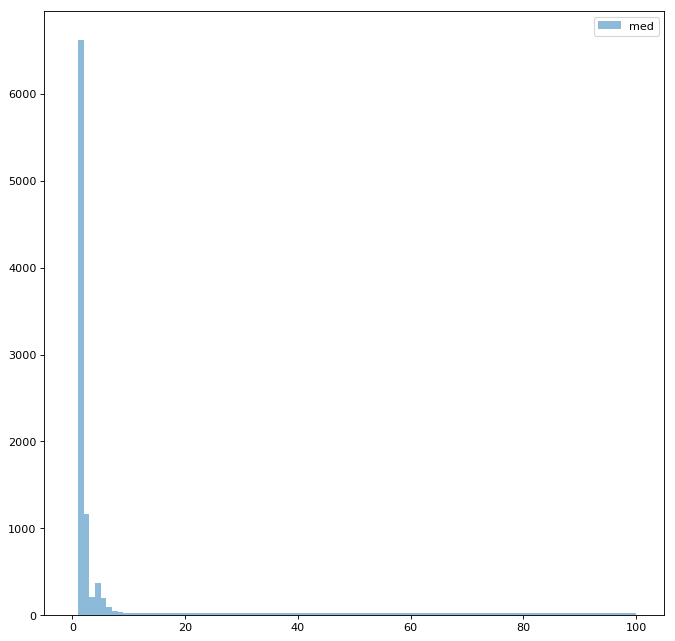

In [232]:
import random
from matplotlib import pyplot

x = [random.gauss(3,1) for _ in range(400)]
y = [random.gauss(4,2) for _ in range(400)]

bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100]

fig = pyplot.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')

pyplot.hist(tarlen[0], bins, alpha=0.5, label='med')
pyplot.legend(loc='upper right')
pyplot.show()